# Face Obstruction Detection Multi-Label

.............................

## Import the dataset

In [199]:
import pandas as pd
import numpy as np
import cv2
import imghdr
import os
import pathlib
from PIL import Image
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,TensorBoard, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
import shutil
from keras.metrics import Precision, Recall, Accuracy
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns
from keras.models import load_model

In [10]:
images_folder = "./data/face-images/images"

df = pd.read_csv("data/face-images/dataset.csv")
df.head()

,id,glasses,hand,mask,none,other,sunglasses
0,i00001.jpg,1,0,0,0,0,0
1,i00002.jpg,1,0,0,0,0,0
2,i00003.jpg,1,0,0,0,0,0
3,i00004.jpg,1,0,0,0,0,0
4,i00005.jpg,1,1,0,0,0,0


Rearange the columns

In [8]:
df = df[['id', 'glasses', 'hand', 'mask', 'sunglasses', 'other', 'none']]
df.head()


,id,glasses,hand,mask,sunglasses,other,none
0,i00001.jpg,1,0,0,0,0,0
1,i00002.jpg,1,0,0,0,0,0
2,i00003.jpg,1,0,0,0,0,0
3,i00004.jpg,1,0,0,0,0,0
4,i00005.jpg,1,1,0,0,0,0


We need to add the image size and channels as features

In [14]:
def get_image_metadata(df_row):
    file_path = os.path.join(images_folder, df_row['id'])
    image = Image.open(file_path)
    width, height = image.size
    channels = image.mode
    return width, height, image.format, channels

df['image_width'], df['image_height'], df['format'], df['channels'] = zip(*df.apply(get_image_metadata, axis=1))

df.head()

,id,glasses,hand,mask,none,other,sunglasses,image_width,image_height,format,channels
0,i00001.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
1,i00002.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
2,i00003.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
3,i00004.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
4,i00005.jpg,1,1,0,0,0,0,256,256,JPEG,RGB


We want to see if we have different formats, channels and sizes

In [23]:
df['format'].value_counts(), df['channels'].value_counts()

(format
 JPEG    11871
 Name: count, dtype: int64,
 channels
 RGB    11871
 Name: count, dtype: int64)

We see that we have only JPEG format and RGB channels, this is good so far

Now we want to see what width and height we have for the images

Plotting the width distribution

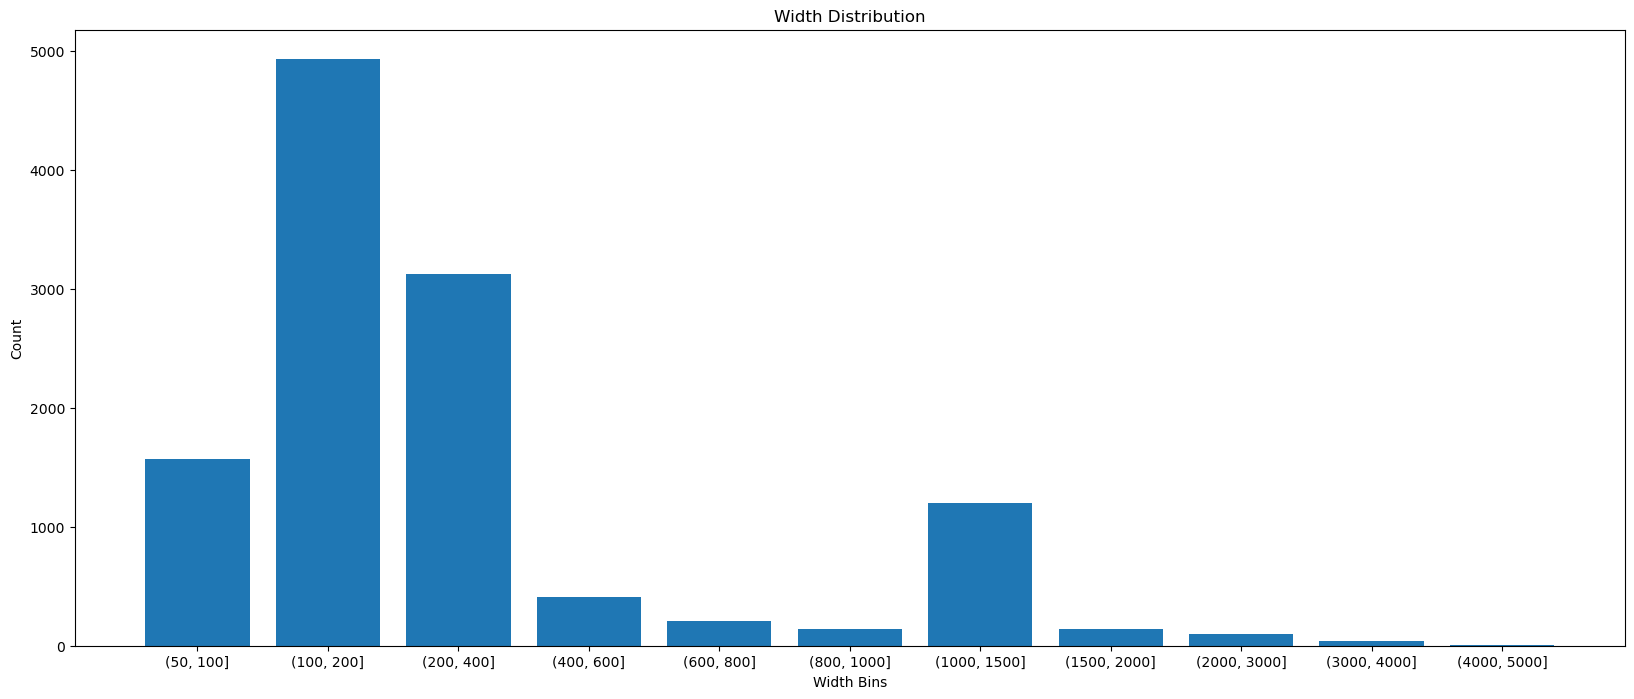

In [44]:
# Define bins for width data
bins = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000]  # Define the bin edges according to your requirements

# Bin the data
df['width_bin'] = pd.cut(df['image_width'], bins=bins)

# Count the occurrences in each bin
bin_counts = df['width_bin'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(20, 8))
plt.bar(bin_counts.index.astype(str), bin_counts.values)
plt.xlabel('Width Bins')
plt.ylabel('Count')
plt.title('Width Distribution')
plt.show()

Same for height

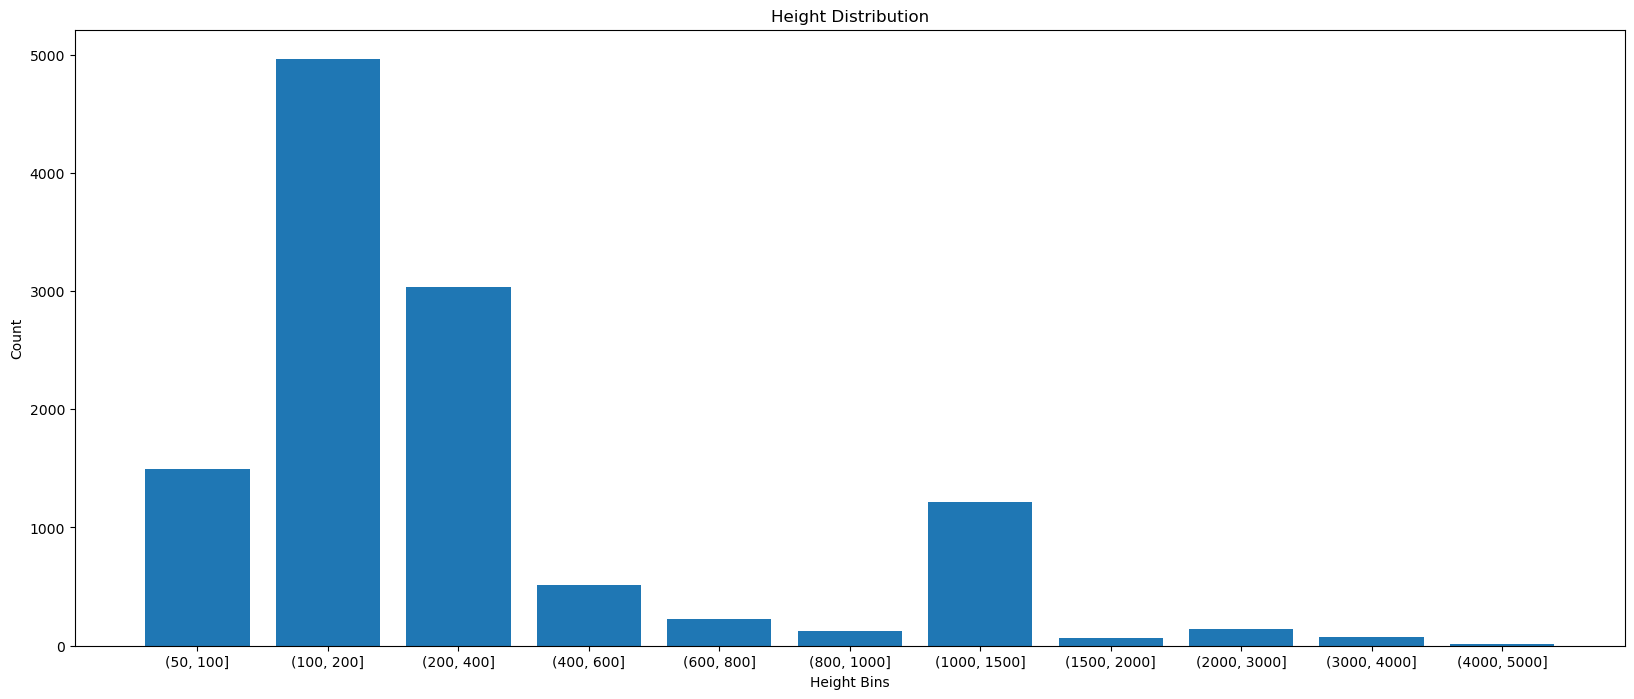

In [45]:
# Define bins for width data
bins = [50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000]  # Define the bin edges according to your requirements

# Bin the data
df['height_bin'] = pd.cut(df['image_height'], bins=bins)

# Count the occurrences in each bin
bin_counts = df['height_bin'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(20, 8))
plt.bar(bin_counts.index.astype(str), bin_counts.values)
plt.xlabel('Height Bins')
plt.ylabel('Count')
plt.title('Height Distribution')
plt.show()

In [46]:
df.drop(columns=['width_bin', 'height_bin'], inplace=True)

In [48]:
df.sort_values(by='image_width')

,id,glasses,hand,mask,none,other,sunglasses,image_width,image_height,format,channels
6128,i09932.jpg,0,0,0,1,0,0,51,51,JPEG,RGB
3330,i05173.jpg,1,0,1,0,0,0,56,90,JPEG,RGB
6778,i10582.jpg,0,0,0,1,0,0,58,58,JPEG,RGB
5326,i09130.jpg,0,0,0,1,0,0,58,58,JPEG,RGB
4372,i08176.jpg,0,0,0,1,1,0,59,59,JPEG,RGB
...,...,...,...,...,...,...,...,...,...,...,...
10441,i17697.jpg,0,0,0,0,0,1,4608,3440,JPEG,RGB
10442,i17698.jpg,0,0,0,0,0,1,4608,3440,JPEG,RGB
4105,i07360.jpg,0,0,1,0,0,0,4734,5412,JPEG,RGB
4056,i07311.jpg,0,0,1,0,0,0,4912,3264,JPEG,RGB


We want to resize some images to see how they looks after

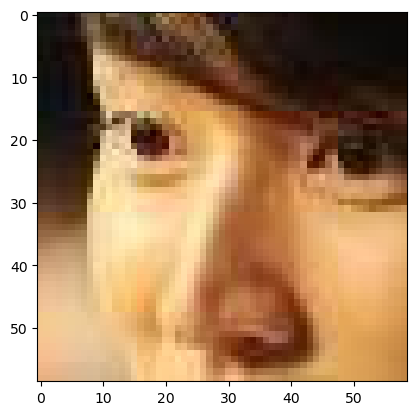

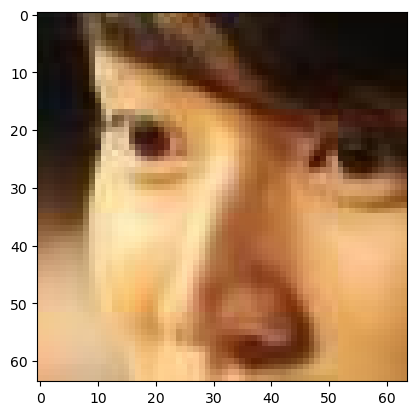

In [80]:
img_size = 64

def get_image(image_path):
    img = cv2.imread(image_path)
    im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return im_rgb

new_image = get_image(os.path.join(images_folder, "i08176.jpg"))
plt.imshow(new_image)
plt.show()


def resize_image(image, height, width):
    return tf.image.resize(image, (height, width))

resized_image = resize_image(new_image, img_size, img_size)
plt.imshow(resized_image.numpy().astype(int))
plt.show()

In [82]:
df.sort_values(by='other')

,id,glasses,hand,mask,none,other,sunglasses,image_width,image_height,format,channels
0,i00001.jpg,1,0,0,0,0,0,256,256,JPEG,RGB
7657,i11462.jpg,0,0,0,1,0,0,80,80,JPEG,RGB
7658,i11463.jpg,0,0,0,1,0,0,102,102,JPEG,RGB
7659,i11464.jpg,0,0,0,1,0,0,106,106,JPEG,RGB
7660,i11465.jpg,0,0,0,1,0,0,105,105,JPEG,RGB
...,...,...,...,...,...,...,...,...,...,...,...
1666,i01721.jpg,0,0,0,0,1,0,180,180,JPEG,RGB
9831,i16493.jpg,0,0,0,0,1,0,256,256,JPEG,RGB
1664,i01719.jpg,0,0,0,0,1,0,180,180,JPEG,RGB
1678,i01733.jpg,0,1,0,0,1,0,180,180,JPEG,RGB


Display a single image

In [85]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

def show_image(images_folder, image):
    img_path = os.path.join(images_folder, image)
    img = Image.open(img_path)
    img.show()

show_image(images_folder,'i01733.jpg')

We want to see the unique combination of labels per images

In [125]:
label_columns = ['glasses', 'hand', 'mask', 'sunglasses', 'other', 'none']

df['combined_labels'] = df[label_columns].apply(lambda x: '|'.join(map(str, x)), axis=1)

df['combined_labels'].value_counts()

combined_labels
0|0|0|0|0|1    5660
0|0|1|0|0|0    2073
0|0|0|1|0|0    1635
1|0|0|0|0|0     765
0|1|0|0|0|0     685
0|0|0|0|1|0     447
0|1|0|0|1|0     198
1|0|1|0|0|0     147
1|1|0|0|0|0      74
0|0|1|0|1|0      54
0|0|1|1|0|0      44
1|0|0|0|1|0      37
0|1|1|0|0|0      15
0|0|0|0|1|1       8
1|1|0|0|1|0       8
1|0|0|1|0|0       5
0|0|0|0|0|0       3
0|1|0|0|0|1       2
1|1|1|0|0|0       2
1|0|1|0|1|0       2
0|0|0|1|1|0       2
0|1|0|1|0|0       2
0|1|1|0|1|0       1
1|0|1|1|0|0       1
0|0|1|1|1|0       1
Name: count, dtype: int64

We think that the idataet is good and we can moove forward with these images to classify them. We want to perform multi label classification

## Multi label image classification

We need to split the dataset into three parts: 
- training
- validation
- testing


We need to resize the images

We need to convert the images into tesnors and batch them

We need to normalize the tensors from the batches


In [109]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_data(df, labels_columns, train_size=0.7, test_size=0.1, random_state=42):
    """
    Split the data into training, validation, and test sets.

    Parameters:
    - df: The DataFrame containing the data.
    - labels_columns: A list containing the names of columns containing labels.
    - train_size: The proportion of the dataset to include in the training set.
    - test_size: The proportion of the dataset to include in the test set.
    - random_state: The seed used by the random number generator.

    Returns:
    - A tuple containing three DataFrames: train_data, validation_data, and test_data.
    """

    # Split the data into training and the rest by combined labels
    train_data, rest_data = train_test_split(df, train_size=train_size, random_state=random_state)

    # Calculate the remaining percentage
    remaining_size = 1.0 - train_size

    # Split the remaining data into testing and evaluation by combined labels
    valid_data, test_data = train_test_split(rest_data, test_size=test_size / remaining_size, random_state=random_state)

    return train_data, valid_data, test_data

# Usage example:
# Assuming 'df' is your DataFrame containing the data, and 'labels_columns' is a list of columns containing labels
train_data, valid_data, test_data = split_data(df, label_columns)

Now we have 3 datasets for training, validation and testing

In [142]:
image_size = 250
batch_size = 32
seed = 42

def generate_for_class(labels_column, train_dataset, validation_dataset, test_dataset, image_size=250, seed=42, batch_size=32)-> tuple[ImageDataGenerator, ImageDataGenerator]:
    directory_path = "../v2/Garbage classification/"

    train_batches = ImageDataGenerator(
        ###Augmentation layers
        #horizontal_flip=True,
        #vertical_flip=True,
        #zoom_range=0.1,
        rescale=1./255.,
        ).flow_from_dataframe(
        dataframe=train_dataset, 
        directory=images_folder,
        x_col = 'id',
        y_col = labels_column,
        target_size=(image_size,image_size),shuffle=True, seed=seed, class_mode='raw', batch_size=batch_size
        )


    # extract images to validation set
    valid_batches = ImageDataGenerator(
        rescale=1./255.,
        ).flow_from_dataframe(
        dataframe=validation_dataset,
        directory=images_folder,
        x_col = 'id',
        y_col = labels_column, 
        target_size=(image_size,image_size),shuffle=True, seed=seed, class_mode='raw', batch_size=batch_size,
    )

    # extract images to testing set
    test_batches = ImageDataGenerator(
        rescale=1./255.,
        ).flow_from_dataframe(
        dataframe=test_dataset,
        directory=images_folder,
        x_col = 'id',
        y_col = labels_column, 
        target_size=(image_size,image_size),shuffle=True, seed=seed, class_mode='raw', batch_size=batch_size,
    )
    
    return train_batches, valid_batches, test_batches

Now we have everything prepared from the data perspective

Label mapping 

In [126]:
label_mapping = {
    'glasses': 0,
    'hand': 1,
    'mask': 2,
    'sunglasses': 3,
    'other': 4,
    'none': 5
}

### Build the model

In [129]:
num_classes = len(label_columns)

small_model = [
  Conv2D(16, (3,3), padding='same', activation='relu', input_shape=(image_size, image_size, 3)),
  MaxPooling2D(),
  Flatten(),
  Dense(64, activation='relu'),
  Dense(num_classes, activation='sigmoid')
]

model = Sequential(small_model)

Compile the model

In [131]:
def compile_model(model): 
    model.compile(optimizer='Adam', loss=tf.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'accuracy'])
    return model

model = compile_model(model)

In [132]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 250, 250, 16)      448       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 125, 125, 16)     0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 250000)            0         
                                                                 
 dense_2 (Dense)             (None, 64)                16000064  
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 16,000,902
Trainable params: 16,000,902
Non-trainable params: 0
____________________________________________

### Define callbakcs

In [138]:
logdir = 'logs'

# Clean logs data before running training
if os.path.exists(logdir):
    shutil.rmtree(logdir)

# logger callback
logger_callback = TensorBoard(log_dir=logdir)

# monitor the training loss and stop training if the loss doesn't improve for 5 consecutive epochs
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5) 

# checkpoint callback - save the best model callback
def create_model_checkpoint(model_path, metric='val_accuracy') -> ModelCheckpoint:
    model_checkpoint = ModelCheckpoint(model_path, monitor=metric, verbose=1, save_best_only=True)
    return model_checkpoint

def get_logger_callback(model_name):
    return logger_callback = TensorBoard(log_dir=os.join.path(logdir, model_name))  
    

### Training 

In [143]:
train_batches, validation_batches, testing_batches = generate_for_class(label_columns, train_data, valid_data, test_data)

Found 8309 validated image filenames.
Found 2374 validated image filenames.
Found 1188 validated image filenames.


In [144]:
epochs = 10

history = model.fit(train_batches, validation_data=validation_batches, epochs=epochs,
                    callbacks=[logger_callback, early_stopping_callback, create_model_checkpoint('./models/small-model.h5')])

Epoch 1/10
260/260 [==============================] - ETA: 0s - loss: 0.4109 - precision_1: 0.7717 - recall_1: 0.6009 - accuracy: 0.6933
Epoch 1: val_accuracy improved from -inf to 0.75400, saving model to ./models\small-model.h5
260/260 [==============================] - 154s 586ms/step - loss: 0.4109 - precision_1: 0.7717 - recall_1: 0.6009 - accuracy: 0.6933 - val_loss: 0.2122 - val_precision_1: 0.8723 - val_recall_1: 0.6499 - val_accuracy: 0.7540
Epoch 2/10
260/260 [==============================] - ETA: 0s - loss: 0.1604 - precision_1: 0.8942 - recall_1: 0.7456 - accuracy: 0.8242
Epoch 2: val_accuracy improved from 0.75400 to 0.78770, saving model to ./models\small-model.h5
260/260 [==============================] - 146s 560ms/step - loss: 0.1604 - precision_1: 0.8942 - recall_1: 0.7456 - accuracy: 0.8242 - val_loss: 0.1994 - val_precision_1: 0.8816 - val_recall_1: 0.6790 - val_accuracy: 0.7877
Epoch 3/10
260/260 [==============================] - ETA: 0s - loss: 0.1090 - precisio

In [161]:
def fit_model(model, name, epochs):
    history = model.fit(train_batches,
                        validation_data=validation_batches,
                        epochs=epochs,
                        callbacks=[
                                  get_logger_callback(name),
                                  early_stopping_callback,
                                  create_model_checkpoint(f'./models/{name}.h5')])

In [162]:
size_histories = {}

In [ ]:
size_histories['small'] = compile_and_fit(tiny_model, 'sizes-small')

### Plot model performance

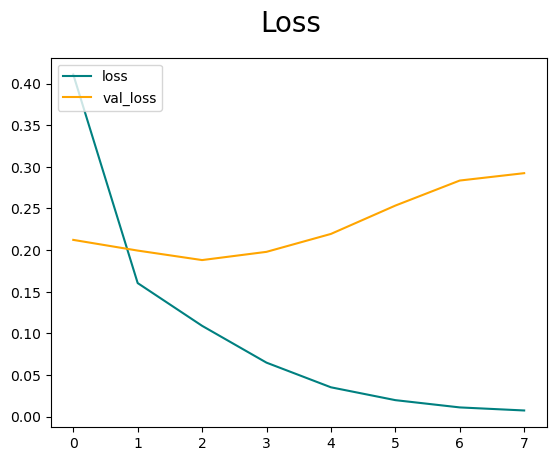

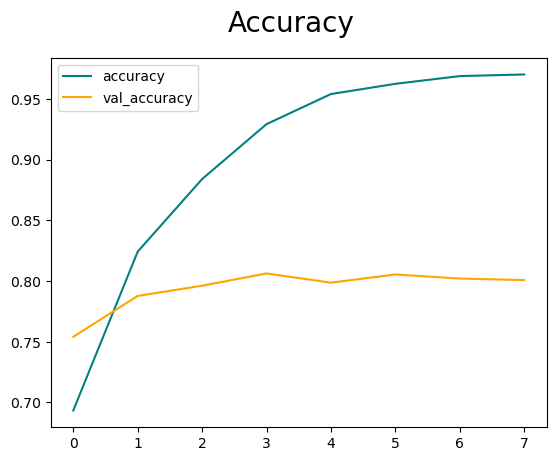

In [148]:
history_metrics = history.history


def plot_metrics(history, metric):
    if metric not in history:
        raise ValueError(f"{metric} not found in history. Available metrics: {', '.join(history.keys())}")
    
    fig = plt.figure()
    plt.plot(history[metric], color='teal', label=metric)
    val_metric = 'val_' + metric
    plt.plot(history[val_metric], color='orange', label=val_metric)
    fig.suptitle(metric.capitalize(), fontsize=20)
    plt.legend(loc="upper left")
    plt.show()

plot_metrics(history_metrics, metric='loss')
plot_metrics(history_metrics, metric='accuracy') 


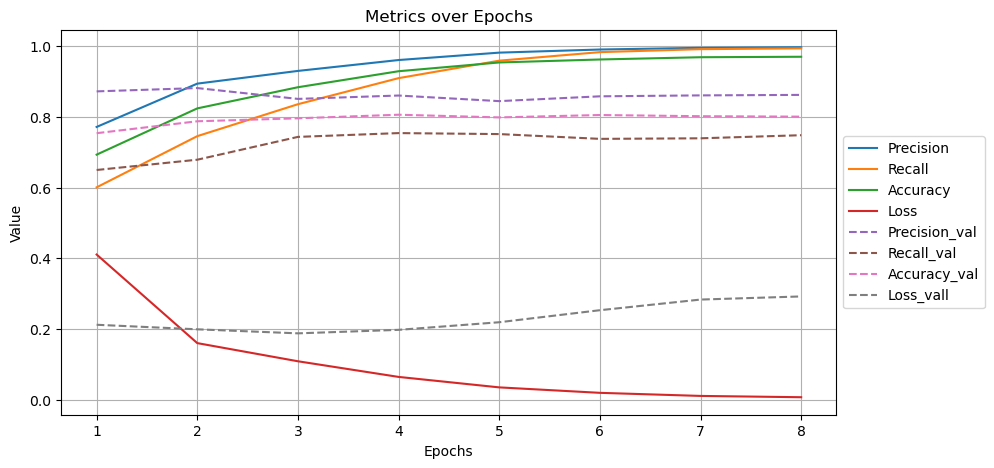

In [156]:
# Extracting metrics from history
precision = history.history['precision_1']
recall = history.history['recall_1']
accuracy = history.history['accuracy']
loss = history.history['loss']

precision_val = history.history['val_precision_1']
recall_val = history.history['val_recall_1']
accuracy_val = history.history['val_accuracy']
loss_val = history.history['val_loss']

# Creating an array of epoch numbers
epochs = np.arange(1, len(precision) + 1)

# Plotting the metrics
plt.figure(figsize=(10, 5))

#Training metrics
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, loss, label='Loss')

#Validation metrics
plt.plot(epochs, precision_val, label='Precision_val',  linestyle='--')
plt.plot(epochs, recall_val, label='Recall_val',  linestyle='--')
plt.plot(epochs, accuracy_val, label='Accuracy_val',  linestyle='--')
plt.plot(epochs, loss_val, label='Loss_vall', linestyle='--')

plt.title('Metrics over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)

plt.show()

### Predict on testing data 

### Load the model

In [200]:
small_model = load_model(os.path.join('models', 'small-model.h5'))

In [ ]:
precision = Precision()
recall = Recall()
accuracy = Accuracy()

# Lists to store true and predicted labels for F1-score calculation
true_labels = []
predicted_labels = []

limit = 100
counter = 0

for batch in testing_batches:
    X, y = batch 
    yhat = small_model.predict(X)

    # Convert the label to one-hot encoding
    #y_one_hot = tf.one_hot(y, depth=num_classes)

    # Obtain the predicted class labels (the classes with the highest probability for each sample)
    predicted_class = np.argmax(yhat, axis=1)
    
    # Convert the label to one-hot encoding
    predicted_one_hot = tf.one_hot(predicted_class, depth=num_classes)
    
    precision.update_state(y, predicted_one_hot)
    recall.update_state(y, predicted_one_hot)
    accuracy.update_state(y, predicted_one_hot)

    true_labels.extend(y)
    predicted_labels.extend(predicted_one_hot)

    counter += 1
    if counter >= limit:
        break

1/1 [==============================] - 0s 85ms/step


In [188]:
predicted_labels

[<tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 1.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([0., 0., 0., 1., 0., 0.], dtype=float32)>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=arra

In [189]:
# Compute F1-score
f1 = f1_score(true_labels, predicted_labels, average='micro')



print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}, F1-score: {f1}')

# Optionally, you can print the classification report for more detailed information
report = classification_report(true_labels, predicted_labels)
print("Classification Report:\n", report)

Precision: 0.8088422417640686, Recall: 0.769440233707428, Accuracy: 0.9277459979057312, F1-score: 0.7886494030082183
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.49      0.56       285
           1       0.68      0.33      0.44       288
           2       0.78      0.81      0.79       610
           3       0.81      0.83      0.82       432
           4       0.29      0.30      0.30       172
           5       0.91      0.93      0.92      1518

   micro avg       0.81      0.77      0.79      3305
   macro avg       0.69      0.61      0.64      3305
weighted avg       0.80      0.77      0.78      3305
 samples avg       0.81      0.79      0.80      3305



c:\Users\Hori\miniconda3\envs\image-classification-env\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[[2785   74]
  [ 146  139]]

 [[2811   45]
  [ 193   95]]

 [[2396  138]
  [ 117  493]]

 [[2629   83]
  [  75  357]]

 [[2847  125]
  [ 120   52]]

 [[1490  136]
  [ 111 1407]]]


<Figure size 1000x800 with 0 Axes>

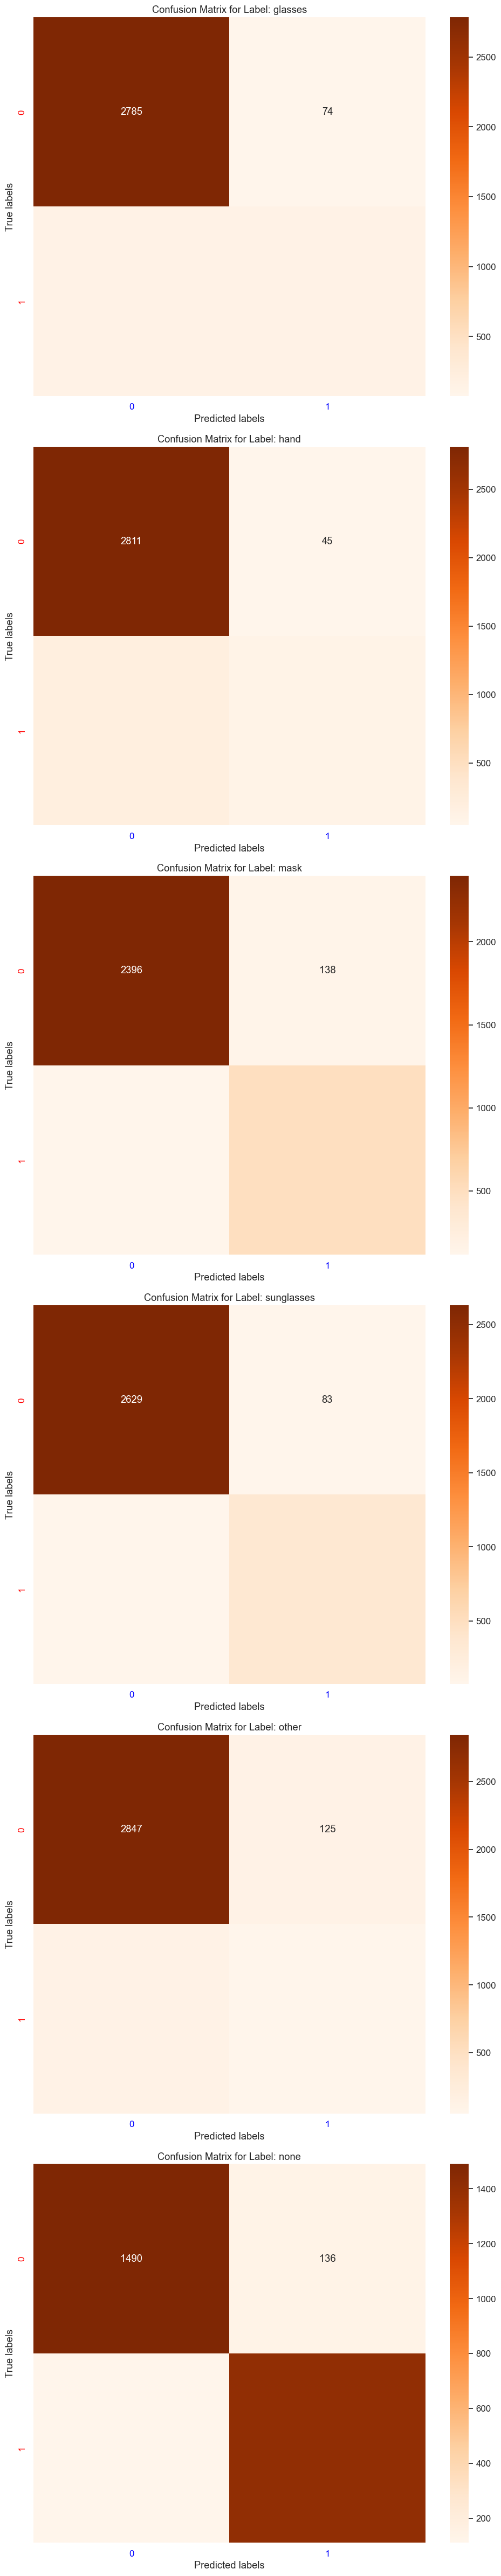

In [198]:
# Compute confusion matrix
cm = multilabel_confusion_matrix(true_labels, predicted_labels)

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale = 1.1)

# Plot confusion matrix for each label
fig, axes = plt.subplots(nrows=len(label_mapping), ncols=1, figsize=(10, 8 * len(label_mapping)))
for i, (label_cm, label_name) in enumerate(zip(cm, label_mapping)):
    ax = axes[i]
    sns.heatmap(label_cm, annot=True, cmap='Oranges', fmt='d', ax=ax)
    ax.set_title(f'Confusion Matrix for Label: {label_name}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.tick_params(axis='x', colors='blue')
    ax.tick_params(axis='y', colors='red')

plt.tight_layout()
plt.show()